In [1]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [40]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.common.value import AbstractValue
from pydrake.geometry import SceneGraphConfig, StartMeshcat, FramePoseVector, GeometryFrame
from pydrake.systems.framework import Context, LeafSystem, BasicVector
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer
from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController, PendulumPlant
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource, LeafSystem, MultibodyPositionToGeometryPose,
    Multiplexer, ConstantVectorSource, Context, ContinuousState
)

from IPython.display import SVG, display
import pydot

In [3]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

<module 'IPQGeometry' from '/home/stephen/Workspace/fall-2024/MEAM-5170/project/Inverted-Pendulum-Quadrotor/src/IPQGeometry.py'>

In [228]:
from scipy.spatial.transform import Rotation
import math

class InvertedPendulumQuadrotor(LeafSystem):
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, use_propeller_torques:bool=True, kF = 1.0, kM=0.0245):
        LeafSystem.__init__(self)
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp

        self._g = 9.81

        self._kF = kF
        self._kM = kM

        self.use_propeller_torques = use_propeller_torques

        if self.use_propeller_torques:
            self.ip_quadrotor_input_port = self.DeclareVectorInputPort("torques", 4)
        else:
            self.ip_quadrotor_input_port = self.DeclareVectorInputPort("zforce_moments", 4)
            
        self.ip_quadrotor_state = self.DeclareContinuousState(16)
        self.DeclareStateOutputPort("state", self.ip_quadrotor_state)

    def DoCalcTimeDerivatives(self, context:Context, dstate:ContinuousState):
        if self.use_propeller_torques:
            torques = self.EvalVectorInput(context, self.ip_quadrotor_input_port.get_index())
            torques = torques.get_value() if torques else np.array([0, 0, 0, 0])
            
            uF = self._kF*torques
            Fz = np.array([sum(uF)])

            uM = self._kM*torques
            M = np.array([
                self._Lq*(uF[1] - uF[3]),
                self._Lq*(uF[2] - uF[0]),
                uM[0] - uM[1] + uM[2] - uM[3]
            ]).T
        else:
            zforce_moments = self.EvalVectorInput(context, self.ip_quadrotor_input_port.get_index())
            zforce_moments = zforce_moments.get_value() if zforce_moments else np.array([0, 0, 0, 0])
            Fz = zforce_moments[0]
            M = np.array(zforce_moments[1:4]).T


        Fg = np.array([0, 0, -self._Mq * self._g]).T


        state = context.get_continuous_state_vector().value()
        rpy = state[3:6]
        w = state[11:14]

        phi, theta, psi = tuple(rpy)

        gq = np.array([[np.sin(phi)*np.sin(psi) + np.cos(phi)*np.sin(theta)*np.cos(psi), 
                      -np.sin(phi)*np.cos(psi) + np.cos(phi)*np.sin(theta)*np.sin(psi),
                      np.cos(phi)*np.cos(theta)]]).T

        pDDt = (Fg + gq @ Fz)/self._Mq

        Zq = np.array([[ 1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        qDt = Zq @ w
        wDt = np.linalg.inv(self._Iq) @ np.cross(self._Iq @ w, w) + np.linalg.inv(self._Iq) @ M

        a, b = state[6], state[7]
        a2 = pow(a,2)
        b2 = pow(b,2)
        ad, bd = state[14], state[15]
        ad2 = pow(ad,2)
        bd2 = pow(bd,2)
        Lp2 = pow(self._Lp,2)
        
        eta = math.sqrt(Lp2 - a2 - b2)
        
        Hab = 4*bd2*(a2 - Lp2) - 8*ad*bd*a*b + 4*ad2*(b2 - Lp2) + 3*pow(eta,3)*self._g
        Fp = np.array([
            (a*Hab)/(4*Lp2*pow(eta,2)),
            (b*Hab)/(4*Lp2*pow(eta,2))
        ]).T
        Bp = np.array([[ 3*(a2 -Lp2)/(4*Lp2), (3*a*b)/(4*Lp2), (3*a*eta)/(4*Lp2)],
                      [(3*a*b)/(4*Lp2), 3*(b2 - Lp2)/(4*Lp2), (3*b*eta)/(4*Lp2)]])

        pdDDt = Fp + Bp @ pDDt

        DDt = np.concatenate((state[8:11], qDt.T, state[14:16], pDDt.T, wDt.T, pdDDt.T))
        dstate.SetFromVector(DDt)
        
        
            
            
        

In [217]:
import IPQGeometry
import importlib
importlib.reload(IPQGeometry)

<module 'IPQGeometry' from '/home/stephen/Workspace/fall-2024/MEAM-5170/project/Inverted-Pendulum-Quadrotor/src/IPQGeometry.py'>

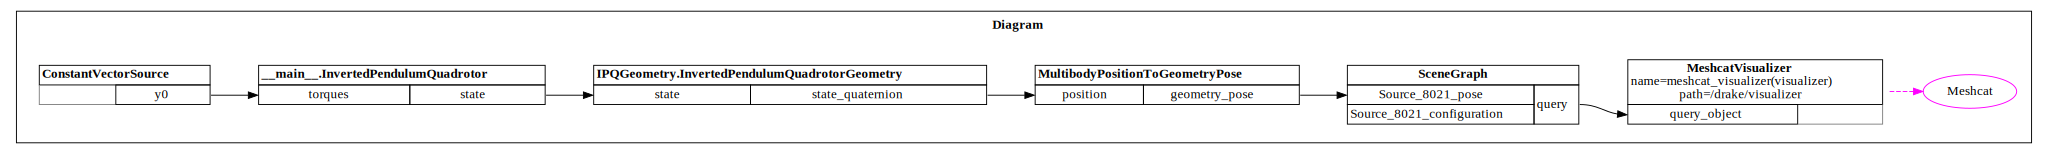

ValueError: math domain error

In [234]:
def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    # builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    
    unit_torque = builder.AddSystem(ConstantVectorSource([2, 2, 2, 2]))
    # multiplexer = builder.AddSystem(Multiplexer([12,2]))
    # builder.Connect(plant.get_output_port(0), multiplexer.get_input_port(0))
    # builder.Connect(pplant.get_output_port(0), multiplexer.get_input_port(1))
    
    
    
    builder.Connect(unit_torque.get_output_port(0), plant.get_input_port(0))
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(5):
        context.SetTime(0.)

        state = np.zeros(16,)
        # state[3] = +0.2
        # state[4] = +0.4
        state[6] = -0.01
        context.SetContinuousState(state)
        simulator.Initialize()
        simulator.AdvanceTo(4.0)

quadrotor_example()

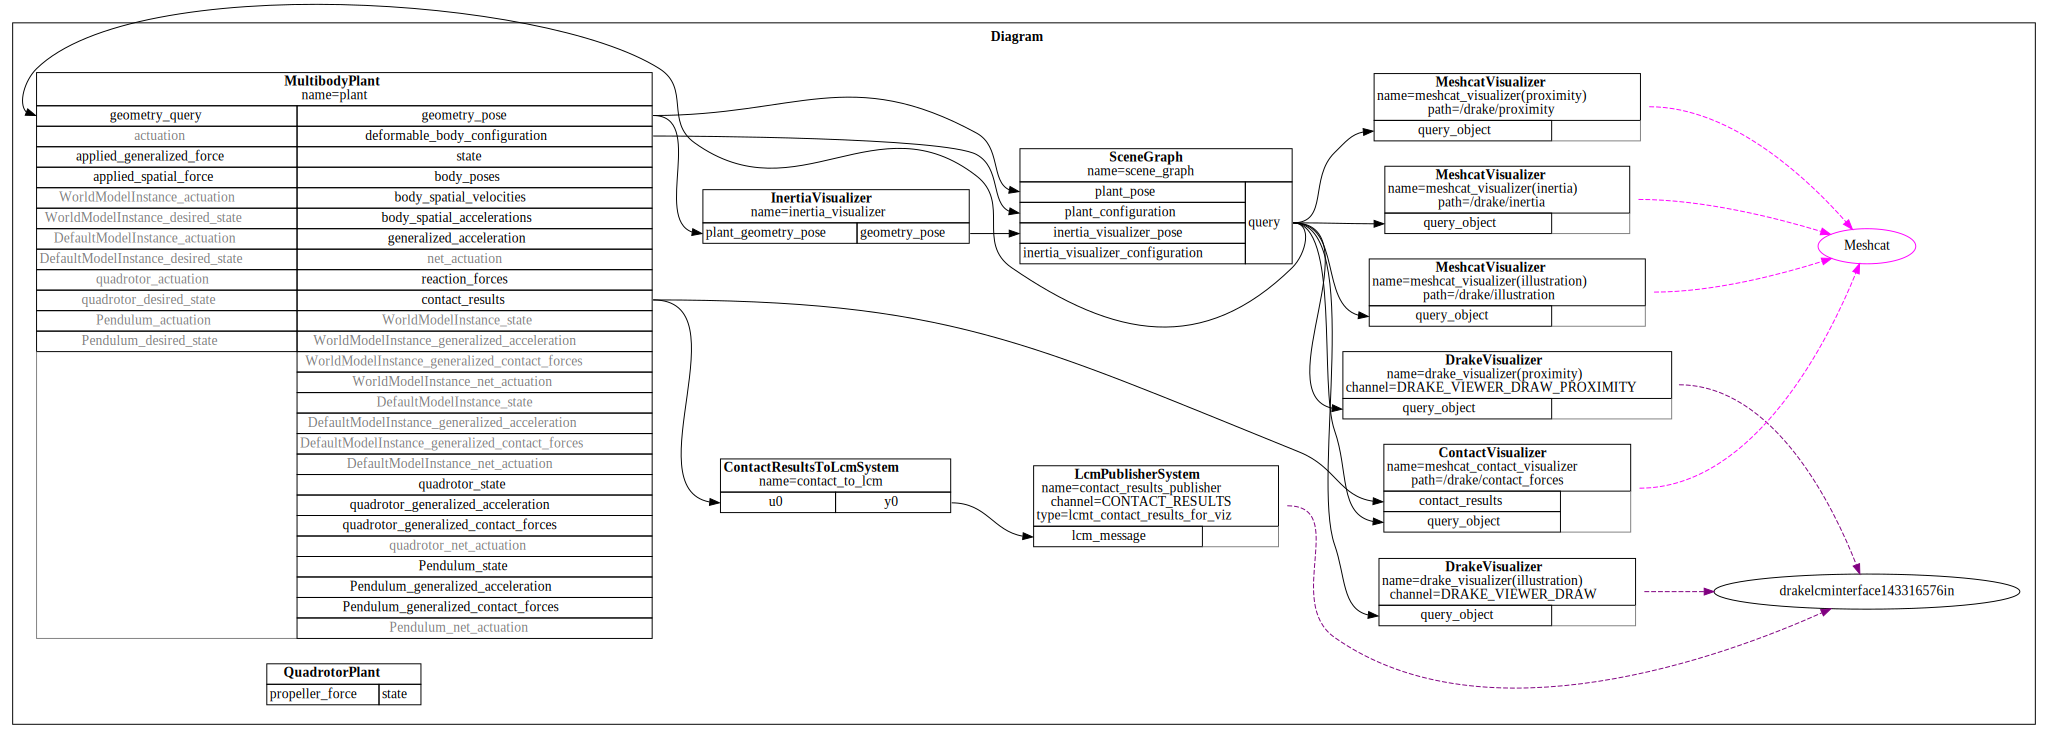

In [150]:
# First we'll choose one of Drake's example model files, a KUKA iiwa arm.
skydio = (
    "res/quadrotor.urdf")
pendulum = (
    "res/Pendulum.urdf"
)

meshcat.Delete()
# meshcat.DeleteAddedControls()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(
    builder, time_step=0.0005)
parser = Parser(plant)

# # Create a model visualizer and add the robot arm.
# # visualizer = ModelVisualizer(meshcat=meshcat)
quadrotor_instance = parser.AddModels(skydio)
parser.AddModels(pendulum)

pendulum_base_frame = plant.GetFrameByName("base")
quadrotor_base_link = plant.GetFrameByName("base_link")
# # plant.WeldFrames(plant.world_frame(), quadrotor_base_link)
plant.WeldFrames(quadrotor_base_link, pendulum_base_frame, X_FM=xyz_rpy_deg([0, 0, 0.03], [0, 180, 0]),)
# # plant.WeldFrames(plant.world_frame(), pendulum_base_frame, X_FM=xyz_rpy_deg([0, 0, 0], [0, 180, 0]),)
# plant.WeldFrames(quadrotor_base_link, pendulum_base_frame)
plant.Finalize()

quad_plant = builder.AddSystem(QuadrotorPlant())
#plant.AddToBuilder(builder, quad_plant.get_output_port(0), scene_graph)

quadrotor_body = plant.GetBodyByName("base_link")
plant.SetDefaultFreeBodyPose(quadrotor_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

n_q = plant.num_positions()

# zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_q + n_v)))
# builder.Connect(quad_plant.get_output_port(), plant.get_state_output_port(quadrotor_instance[0]))

# Add visualization to see the geometries.
AddDefaultVisualization(builder=builder, meshcat=meshcat)
# Start the interactive visualizer.
# Click the "Stop Running" button in MeshCat when you're finished.
diagram = builder.Build()
simulator = Simulator(diagram)

simulator.Initialize()
simulator.set_target_realtime_rate(1.)

# plant_context = diagram.GetMutableSubsystemContext(
#     plant, simulator.get_mutable_context())

# plant.SetFreeBodyPose(plant_context, quadrotor_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

#simulator.AdvanceTo(2.0)

# print(plant.get_state_output_port())
# print(plant.get_actuation_input_port())

In [12]:
print(dir(plant))

['Accept', 'AddBallConstraint', 'AddCouplerConstraint', 'AddDistanceConstraint', 'AddForceElement', 'AddFrame', 'AddJoint', 'AddJointActuator', 'AddModelInstance', 'AddRigidBody', 'AddWeldConstraint', 'AllocateContext', 'AllocateDiscreteVariables', 'AllocateImplicitTimeDerivativesResidual', 'AllocateInputAbstract', 'AllocateInputVector', 'AllocateOutput', 'AllocateTimeDerivatives', 'CalcBiasCenterOfMassTranslationalAcceleration', 'CalcBiasSpatialAcceleration', 'CalcBiasTerm', 'CalcBiasTranslationalAcceleration', 'CalcCenterOfMassPositionInWorld', 'CalcCenterOfMassTranslationalAccelerationInWorld', 'CalcCenterOfMassTranslationalVelocityInWorld', 'CalcConservativePower', 'CalcForceElementsContribution', 'CalcForcedDiscreteVariableUpdate', 'CalcForcedUnrestrictedUpdate', 'CalcGeneralizedForces', 'CalcGravityGeneralizedForces', 'CalcImplicitTimeDerivativesResidual', 'CalcInverseDynamics', 'CalcJacobianAngularVelocity', 'CalcJacobianCenterOfMassTranslationalVelocity', 'CalcJacobianPositionV

###### print(dir(plant.get_input_port(0)))
print(plant.get_input_port(5).get_name())
print(dir(plant.get_desired_state_input_port(quadrotor_instance[0])))
print(plant.GetPositionNames())

In [151]:
print(dir(plant.get_state_output_port()))
print(plant.get_state_output_port().size()) 
# print(plant.get_state_input_port().size()) 
print(dir(plant.get_desired_state_input_port(quadrotor_instance[0]))) 
print(plant.GetVelocityNames())
print(plant.get_input_port(1).size())
print(plant.num_velocities())

['Allocate', 'Eval', 'EvalAbstract', 'EvalBasicVector', '__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_del_orig', 'cache_entry', 'disable_caching_by_default', 'get_data_type', 'get_index', 'get_name', 'get_system', 'size']
19
['Allocate', 'Eval', 'EvalAbstract', 'EvalBasicVector', 'FixValue', 'GetFullDescription', 'HasValue', '__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_del_orig'

In [6]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import HTML, SVG, Latex, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ConstantVectorSource,
                         DiagramBuilder, FirstOrderTaylorApproximation,
                         LinearQuadraticRegulator, MatrixGain,
                         MeshcatVisualizer, MultibodyPlant, Parser,
                         Saturation, SceneGraph, Simulator, StartMeshcat,
                         WrapToSystem)
from pydrake.common.containers import namedview
# from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
#                                       AcrobotPlant, AcrobotState)
# from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
#                                         StabilizingLQRController)
# from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

# from underactuated import FindResource, running_as_notebook
# from underactuated.jupyter import ToLatex
# from underactuated.meshcat_cpp_utils import MeshcatSliders
# from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

PortDataType.kVectorValued


TypeError: DeclareAbstractOutputPort(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.systems.framework.LeafSystem, name: str, alloc: Callable[[], pydrake.common.value.AbstractValue], calc: Callable[[pydrake.systems.framework.Context, pydrake.common.value.AbstractValue], None], prerequisites_of_calc: set[pydrake.systems.framework.DependencyTicket] = {DependencyTicket(15)}) -> pydrake.systems.framework.OutputPort

Invoked with: <__main__.InvertedPendulumQuadrotorGeometry object at 0x7af5d4040710>, 'geometry_pose', <bound method InvertedPendulumQuadrotorGeometry.output_geometry_pose of <__main__.InvertedPendulumQuadrotorGeometry object at 0x7af5d4040710>>